In [7]:
#Importing necessary libraries
import math
import pandas as pd
from math import degrees, radians, sin, cos, sqrt, asin, atan2
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
from matplotlib import pyplot as plt
import descartes
import time
from pyspark.sql.types import *

In [2]:
#EuclideanDistance: given two points, returns the Euclidean distance of the two.
def euclidean(a,b):
    val=[]
    for i in range(len(b)):
        val.append(sqrt((a[0]-b[i][0])**2+(a[1]-b[i][1])**2))
        min_val=min(val)
        index=val.index(min_val)
    return index


#GreatCircleDistance: given two points, returns the great circle distance of the two.
def greatcircle(a,b):
    lst=[]
    for i in range(len(b)):
        lon1=float(a[1])
        lat1=float(a[0])
        lon2=float(b[i][1])
        lat2=float(b[i][0])
        radius = 6371
        dLat = (lat2-lat1) * math.pi / 180
        dLng = (lon2-lon1) * math.pi / 180
        lat1 = lat1 * math.pi / 180
        lat2 = lat2 * math.pi / 180
        val = sin(dLat/2) * sin(dLat/2) + sin(dLng/2) * sin(dLng/2) * cos(lat1) * cos(lat2)    
        ang = radius* 2 * atan2(sqrt(val), sqrt(1-val))
        lst.append(ang)
    min_val=min(lst)
    index=lst.index(min_val)
        
    return index
    

'''closestPoint: given a (latitude/longitude) point and an array of current center points,
returns the index in the array of the center closest to the givenpoint'''

def closestpoint(latlon,cen_lst,d_type):
    label=[]
    for i in range(len(latlon)):
        if d_type=='euclidean':
            dist=euclidean(latlon[i], cen_lst)
            label.append([latlon[i][0],latlon[i][1],dist])
        elif d_type=='greatcircle' or d_type == 'great circle':
            dist=greatcircle(latlon[i], cen_lst)
            label.append([latlon[i][0],latlon[i][1],dist])
    return label

In [3]:
#A fuction to copy a list of old centroids to a list
def copy(centroids):
    oldcentroids=[]
    for i in range(len(centroids)):
        oldcentroids.append([float(centroids[i][0]),float(centroids[i][1])])
    return oldcentroids

In [4]:
#Function to get new centroids based on the old centroids and new mean value
def getnew(res,cen):
    for i in range(len(cen)):
        lat=lon=count=0
        for j in range(len(res)):
            if(res[j][2]==i):
                lat+=res[j][0]
                lon+=res[j][1]
                count+=1
                #print(count)
        cen[i][0]=lat/count
        cen[i][1]=lon/count
    
    return cen

In [5]:
#Subtracting 2 lists to find the lowest mean difference
def subtract(a,b):
    diff=[]
    for i in range(len(a)):
        diff.append([abs(a[i][0]-b[i][0]),abs(a[i][1]-b[i][1])])
    
    return diff

In [6]:
#a condition function loop
def count_itr(lst,cd):
    c=0
    for i in range(len(lst)):
        for j in range(len(lst[i])):
            if lst[i][j] < cd:
                c+=1
    return c

In [7]:
convergeDist=0.5

In [8]:
#A K-Means function to calculate the final centroids and find the perfect clusters based on k
#Recursive function
def k_means(new,k,lst,d_type,cd,c):
    global fnlcentroids
    global res
    res=closestpoint(lst,new,d_type)
    oldcentroids=copy(new)
    newcentroids=getnew(res,new)
    s= subtract(oldcentroids,newcentroids)
    c=count_itr(s,cd) 
    if c == 8:
        print("\nThe final "+str(k)+" cluster centroids are : \n")
        fnlcentroids=copy(newcentroids)
        for i in range(len(fnlcentroids)):        
            print(fnlcentroids[i])
    else:
        return k_means(newcentroids,k,lst,d_type,cd,0)


In [9]:
#Main function to accept user input and process it through k-means function
def main_input():
    global ip
    global d_type
    global k
    #distance type 
    d_type = raw_input("Enter the distance type (Euclidean or great circle): ")
    d_type=d_type.lower()

    #Enter the number of clusters
    k=int(input("Enter the number of clusters: "))
    
    if d_type != "euclidean" and d_type != "greatcircle" and d_type !="great circle":
        print ("\nDistance measure must be either Euclidean or GreatCircle")
    elif k<=0:
        print("Invalid value k")
    else:
        print("Values Accepted")

    #Enter the location of data
    ip=raw_input("Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : ")

    path="s3a://finalgeodata/"+ip+"/*.csv"

    #Reading from the s3 bucket    
    df_full = spark.read.csv(path,header=True)
    
    #Extraction latitude and longitude values into separate dataframe
    df=df_full['latitude','longitude']

    #Converting dataframe into lists
    latlon=[]
    for i in df.collect():
        latlon.append([float(i[0]),float(i[1])]) \

    #Creating random centroids of k clusters
    cen = df.rdd.takeSample(False, k, 1)
    centroids=[]
    for i in cen:
        centroids.append([float(i[0]),float(i[1])])
    
    #First iteration to form clusters based on random centroids
    result=closestpoint(latlon,centroids,d_type)
    
    #Generating new centroids based on the result from 
    newcentroids=getnew(result,centroids)

    #calling k_means function for further iterations
    k_means(newcentroids,k,latlon,d_type,convergeDist,0)

In [10]:
# Visualizing the cluster centroids on world map over the clusters
def visual(dat,cen_data,f):
    #converting to pandas for easier visualization
    data=pd.DataFrame(dat,columns=['latitude','longitude','closest'])
    centers=pd.DataFrame(cen_data,columns=['latitude','longitude'])
    lon=data['longitude']
    lat=data['latitude']
    #creation of a new geo dataframe which has geo location point
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    geometry = [Point(xy) for xy in zip(lon,lat)]
    gdf = GeoDataFrame(data, geometry=geometry)
    gdf['closest'] = gdf.groupby(['closest']).ngroup()
    
    if f=='DBpedialocation':
        ax=world
    else:
        ax=world[world.name == 'United States of America']
    #For the latitude and longitude points    
    gdf.plot(ax=ax.plot(figsize=(25,25)),column='closest', marker='o', markersize=7)
    
    #For plotting the centroids across the map
    plt.scatter(centers['longitude'], centers['latitude'], c='red', s=100, alpha=0.7)


# Test Cases 
through function calls

In [14]:
runtime_lst=[]

## Calculate the k-means clusters for the 'device location' data using k = 5.


### Euclidean Distance (K=5)

In [11]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): euclidean
Enter the number of clusters: 5
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : devicelocation

The final 5 cluster centroids are : 

[40.157042752961964, -121.42080750987161]
[33.68736796258862, -111.0407969858038]
[36.32316584575197, -120.07940337425916]
[34.15899503799398, -117.64226277467071]
[36.692617369965426, -114.56593283595312]


In [68]:
#runtime_lst.append([k,ip,d_type,'Y',run_time])

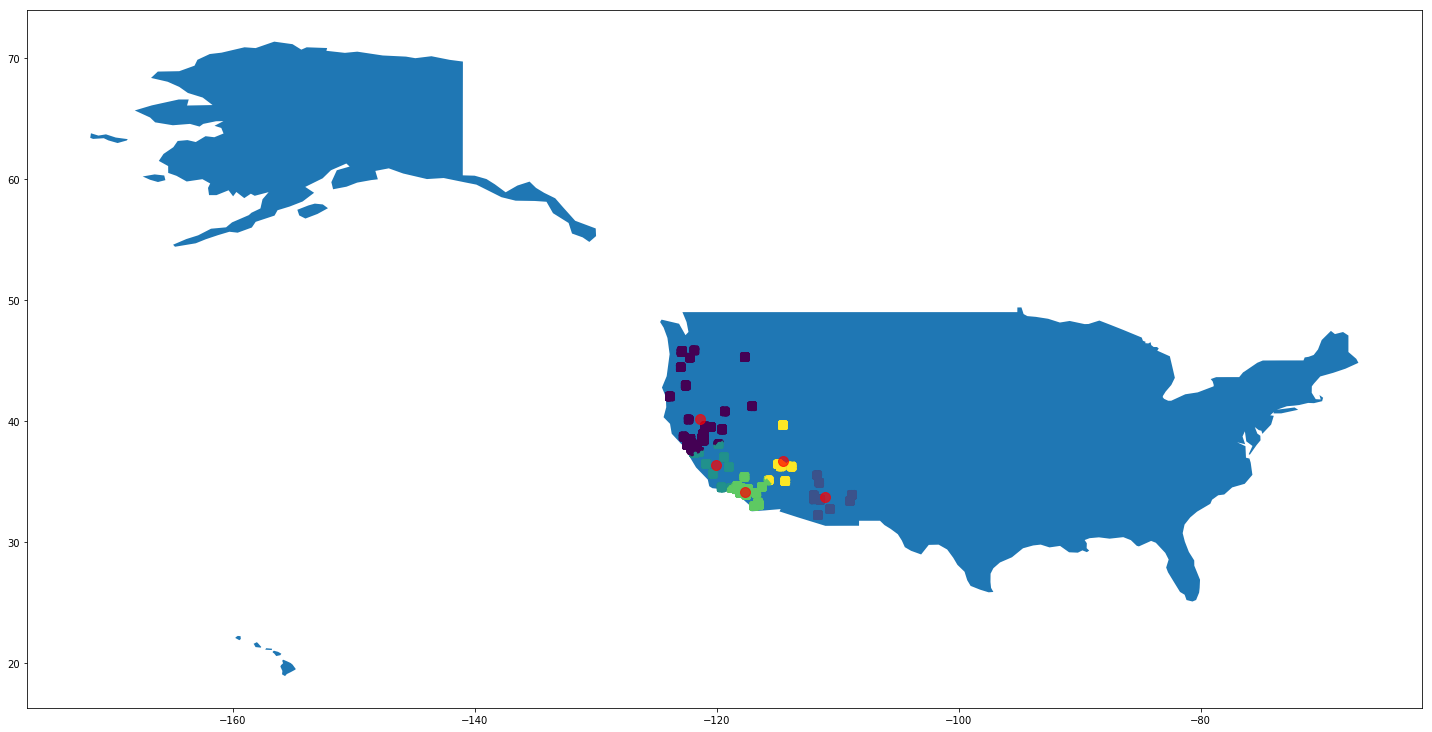

In [22]:
visual(res,fnlcentroids,ip)

### Great Circle Distance (K=5)

In [45]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): greatcircle
Enter the number of clusters: 5
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : devicelocation

The final 5 cluster centroids are : 

[40.12478474775874, -121.39079570185872]
[33.68736796258862, -111.0407969858038]
[36.15518661752166, -119.95907079550055]
[34.137993633977196, -117.61195155252324]
[36.76355642842789, -114.5180902595356]


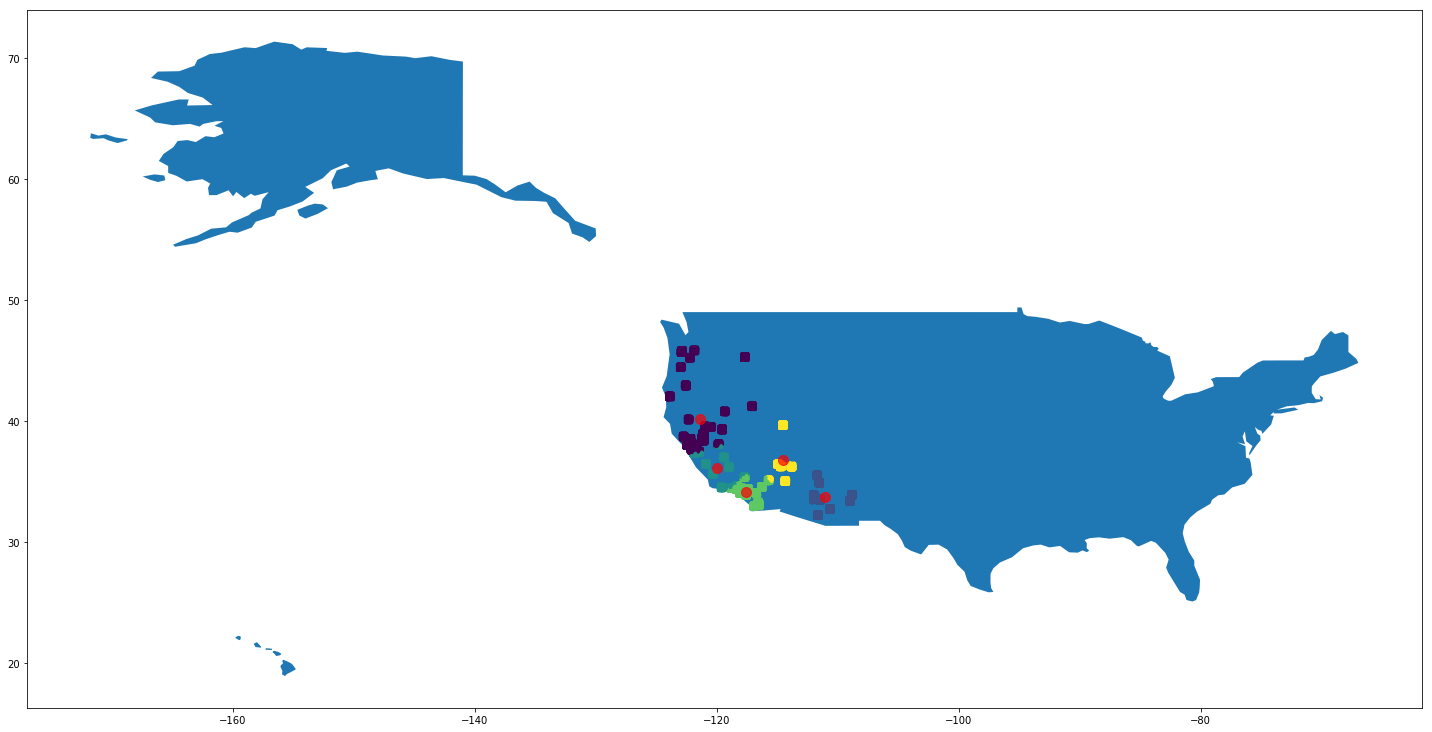

In [14]:
visual(res,fnlcentroids,ip)

## Calculate the k-means clusters for the 'synthetic location' data using k = 2 and k = 4.


When using k=2 we are getting an excessive recursion error, beacuse of low number of clusters a final centroid cannot be determined

So, we will proceed with k=6

### Euclidean Distance (K=4)

In [209]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): euclidean
Enter the number of clusters: 4
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : syntheticlocation

The final 4 cluster centroids are : 

[38.12783927466309, -116.81748310387779]
[39.49581380224827, -84.82339859542058]
[40.33434223421336, -75.08766949408299]
[31.611287793309543, -89.26987508661901]


In [141]:
#runtime_lst.append([k,ip,d_type,'Y',run_time])

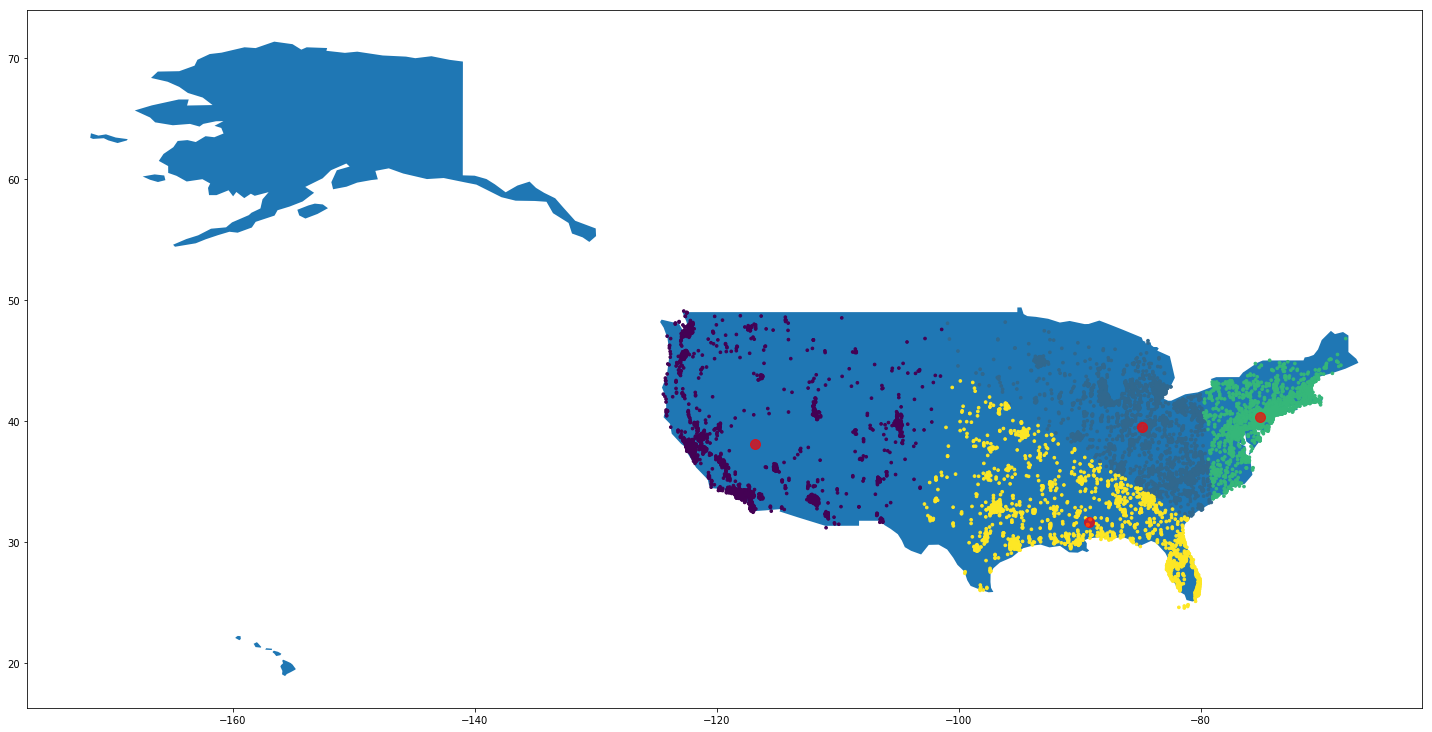

In [16]:
visual(res,fnlcentroids,ip)

### Great Circle Distance (K=4)

In [29]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): greatcircle
Enter the number of clusters: 4
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : syntheticlocation

The final 4 cluster centroids are : 

[38.09903534156898, -116.80393728087164]
[40.730331544666434, -87.10321542024859]
[39.92395340248137, -75.8316053633115]
[31.35557746482054, -87.62126184195326]


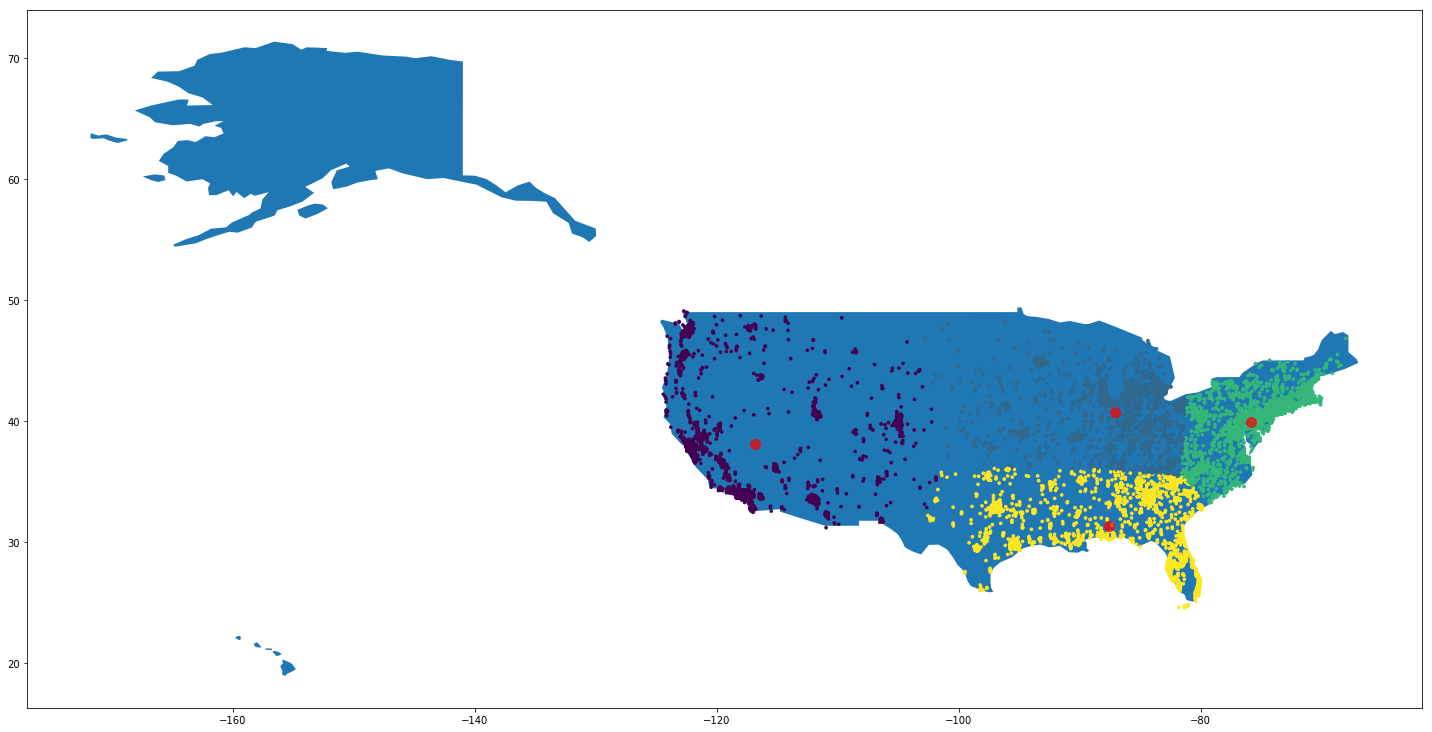

In [18]:
visual(res,fnlcentroids,ip)

### Euclidean (K=6)

In [54]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): euclidean
Enter the number of clusters: 6
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : syntheticlocation

The final 6 cluster centroids are : 

[35.313038536885145, -81.34892717072476]
[41.36029467653451, -84.13998788744364]
[36.12043640348888, -93.6060415545331]
[38.09691698870776, -116.95361423328428]
[40.79930800822953, -74.49536791281987]
[29.177990342561365, -83.79173607495581]


In [72]:
#runtime_lst.append([k,ip,d_type,'Y',run_time])

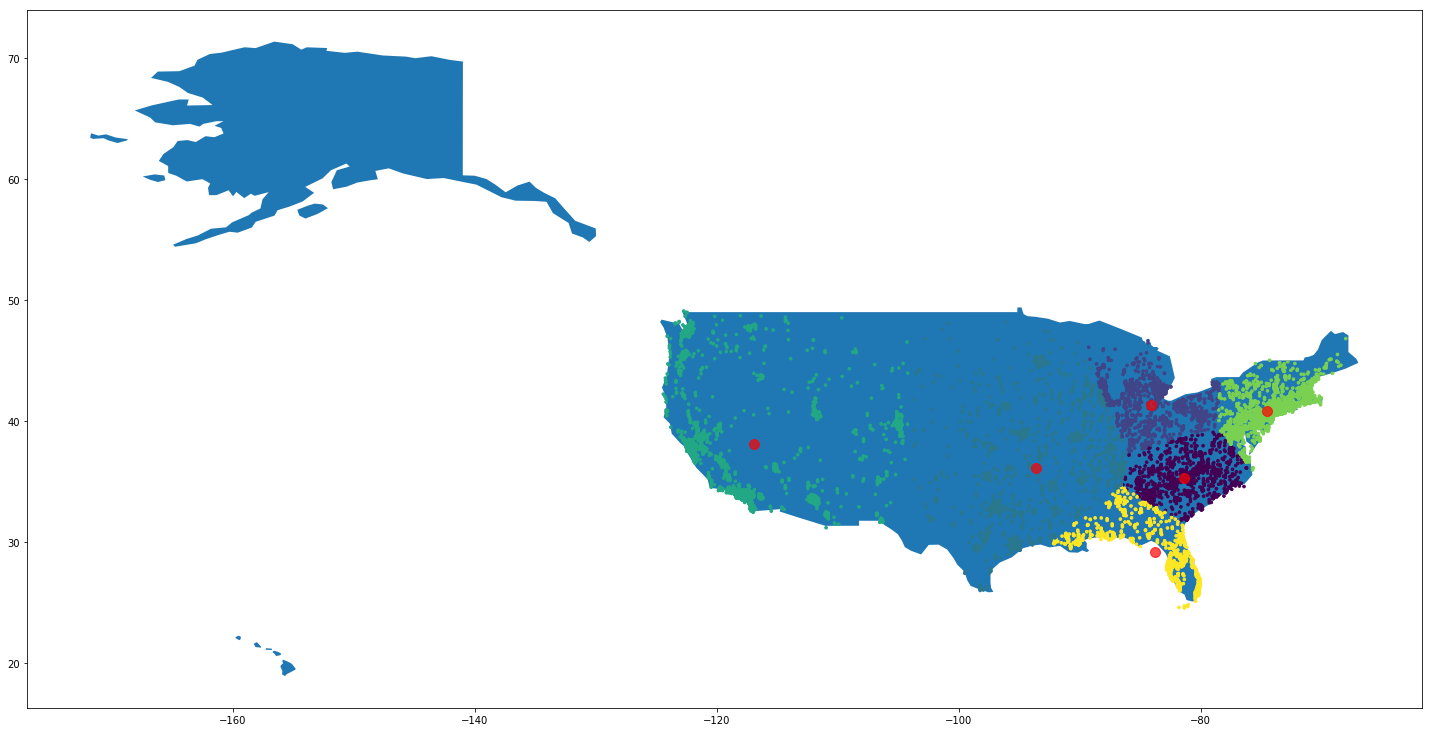

In [35]:
visual(res,fnlcentroids,ip)

## Calculate the k-means clusters for the large-scale 'DBpedia location' data and k=6

### Euclidean Distance (K=6)

In [156]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): euclidean
Enter the number of clusters: 6
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : DBpedialocation

The final 6 cluster centroids are : 

[-7.840330446683233, 1.3228909083384508]
[37.59710655722098, -89.85030922575844]
[49.07906221411929, 1.52262612337139]
[31.150790097921895, 56.85464006626643]
[19.67447539607755, 116.70482324662137]
[49.59257025632822, 19.14317546004478]


In [48]:
#runtime_lst.append([k,ip,d_type,'Y',run_time])

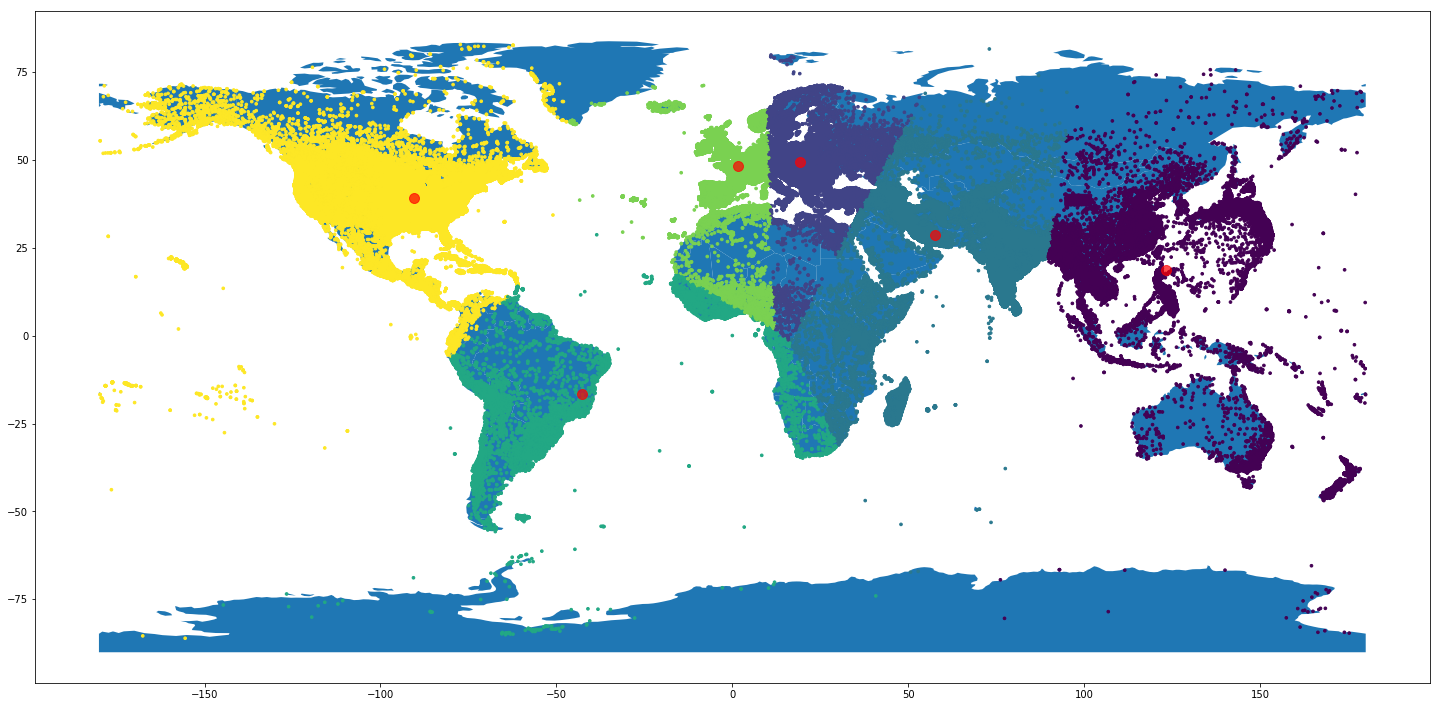

In [20]:
visual(res,fnlcentroids,ip)

### Great Circle Distance (K=6)

In [14]:
start_time = time.time()
main_input()
run_time = time.time() - start_time

Enter the distance type (Euclidean or great circle): greatcircle
Enter the number of clusters: 6
Values Accepted
Enter the input folder(devicelocation, syntheticlocation,  DBpedialocation) : DBpedialocation

The final 6 cluster centroids are : 

[19.324288650015, 116.12891011378528]
[49.91504313121965, 19.080996532714035]
[28.290073382483115, 55.70926856642373]
[-21.700754197704878, -58.344664477955305]
[46.942940118165225, 1.185583178452708]
[39.37857794147885, -90.41250690694326]


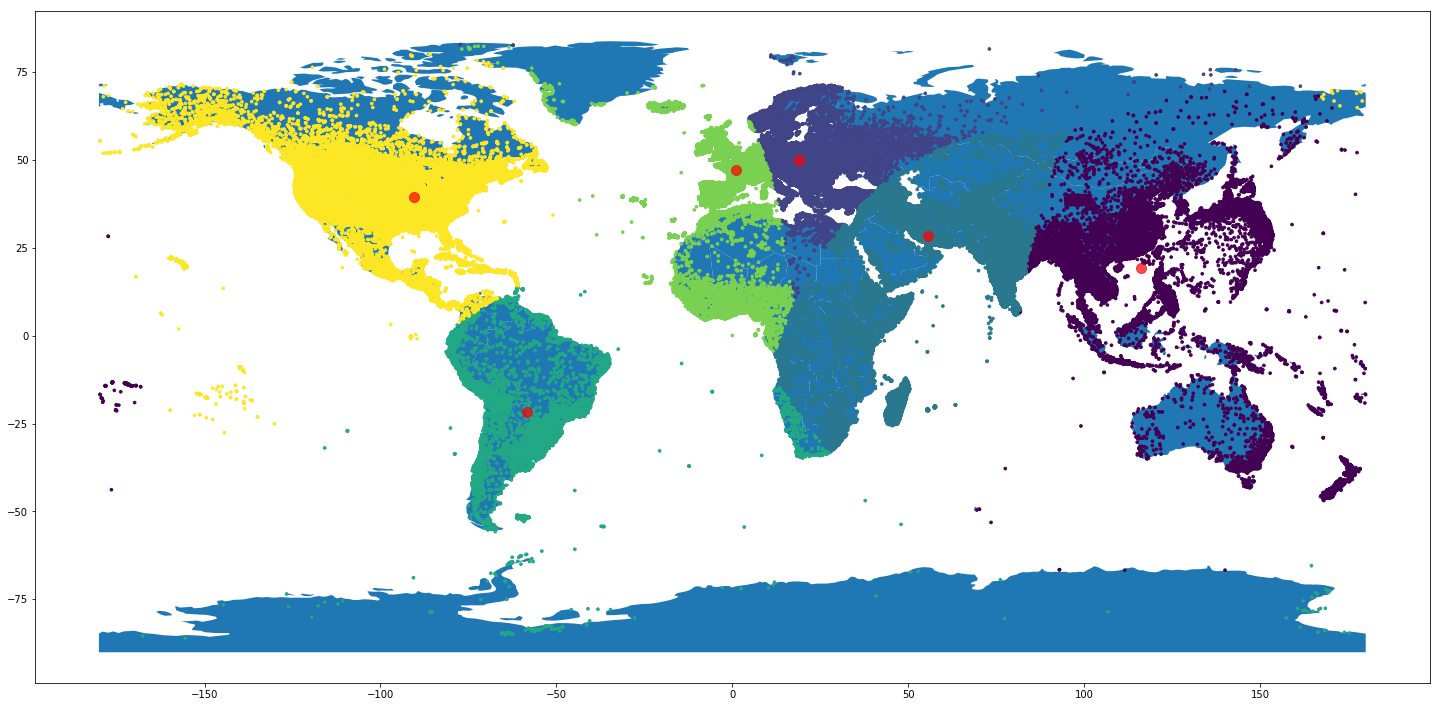

In [22]:
visual(res,fnlcentroids,ip)

### Argue, what choice of k makes sense by considering the problem context, i.e., what could the clusters actually mean/represent?

As of my observations, by calculating the final cluster centers for 3 datasets to both distance types, minumum k(number of clusters) value has to be greater than or equal to 4.

By placing k values as 2 or 3, we will be facing an Runtime error "RuntimeError: maximum recursion depth exceeded in cmp", so it may because of lower number of clusters, the model cannot predict a specific centroid for the given dataset.

The clusters can be used to interpret a kind of group each cluster represents based on the centroids.

In the above test cases, by placing k value as 2 or 3 , the points are unable to decide which cluster group it belongs to. Therefore, by increasing the minimum number of clusters to 4 for a huge dataset, it can find its centroids easily.

## Visualize the clusters and cluster centers (use a random subset of data points for the last dataset) for both distance measures. Can you observe a difference?

As observed from the visualizations above for 3 datasets,

we cannot see any edges of 'device' location data, because of low number of datapoints and because they are gathered around a specific area on the map.

Whereas, we can slightly see edges for 'synthetic' location data as the points are scattered all over U.S. We can also see that there are sharp edges between clusters when we use 'Euclidean distance' and nicer curvier edges by using Greatcircle distance'.

Finally, same can be observed in case of 'DBpedia' location data, the data is spread all over the world and the edges are sharp and straight whereas by using 'Greatcircle distance', nicer and smoother edges can be seen.

# Runtime Analysis

#### After clearing the runtimes from the server, i formed a dataframe with Spark

#### Because my kernel is being failed constantly, to save time i have also uploaded my dataframe to s3 bucket

In [ ]:
#schema for spark dataframe
myschema=StructType([ StructField("k", IntegerType())\
                       ,StructField("data", StringType(), True)\
                       ,StructField("d_type", StringType(), True)\
                       ,StructField("cache", StringType(), True)
                        ,StructField("Runtime(sec)", LongType(), True)])
                     
#runtime_df is the list of runtimes   
df=spark.createDataFrame(df,schema=myschema)

#Writing the dataframe to s3 bucket
df.write.csv("s3a://finalgeodata/out",header=True)


In [1]:
#Reading the dataframe from S3
df=spark.read.csv("s3a://finalgeodata/out/*csv",header=True)

In [2]:
#Conveting to pandas for easier computation
df=df.toPandas()

In [3]:
#Pre-processing
df=df.astype({'k': 'int32'})
df=df.astype({'Runtime(sec)': 'float'})

In [4]:
df=df.sort_values(by=['data','k'])

In [5]:
#dataframe on runtimes
df

,k,data,d_type,cache,Runtime(sec)
1,6,DBpedialocation,euclidean,N,68.512020
4,6,DBpedialocation,euclidean,Y,45.063866
2,5,devicelocation,euclidean,N,29.084178
7,5,devicelocation,euclidean,Y,24.517869
3,4,syntheticlocation,euclidean,N,11.557487
6,4,syntheticlocation,euclidean,Y,8.489901
0,6,syntheticlocation,euclidean,N,13.454243
5,6,syntheticlocation,euclidean,Y,8.024613


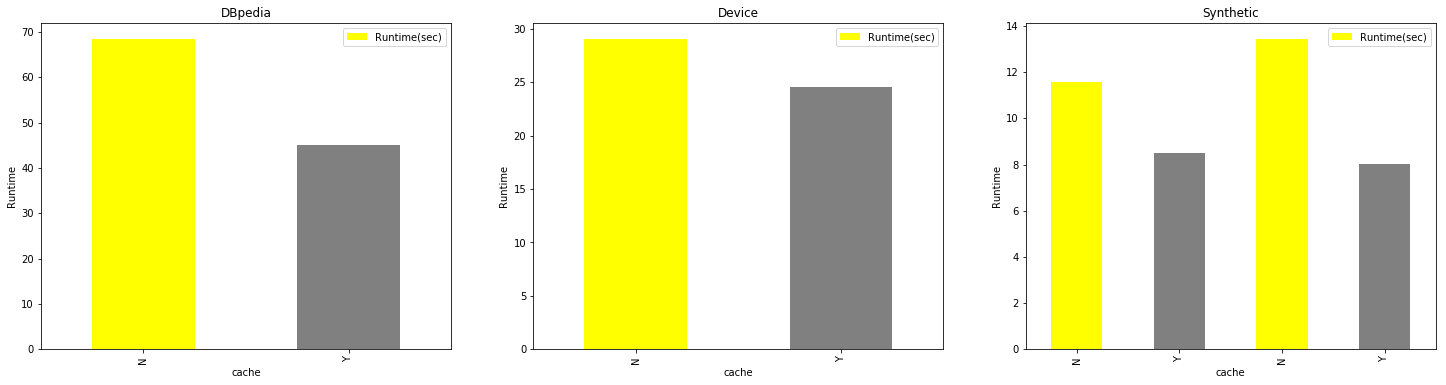

In [13]:
#Bar plot using sub plots and visualizing
num= len(df)/2 - 1
fig, axs = plt.subplots(1, num)
for i in range(num):
    s = 2*i
    subdf = df[s:s+2]
    if s==4:
        subdf=df[4:8] 
    subdf.plot(ax=axs[i],x='cache',y='Runtime(sec)',kind="bar",color=['yellow', 'grey'],figsize=(25,6),legend=True)
    
    axs[0].set_title('DBpedia')
    axs[1].set_title('Device')
    axs[2].set_title('Synthetic')
    axs[i].set_ylabel('Runtime')

the first set in synthetic sub plot is for k=4 and the second part is for k=6

### Findings
From the above representation based on persist and non-persist data, we observe:

For Device Location and k=5, the algorithm ran faster when it is cached with a difference of almost 5 seconds when compared to both the runtimes.

For Synthetic Location, k=4 and k=6, not much change is observed i.e a cached model ran approx 4.5 seconds faster in both the cases.

For DBpedialocation , k=6, cached algorithm executed 9 seconds faster than non-persistant one.

Final Conclusion is that not much difference is observed in case of smaller dataset, but is more when compared to a larger one and caching the datasets has proved to increase the efficiency and decrease the runtime of the algorithm.